In [1]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter, gauss_spline, cspline1d, medfilt, wiener, cubic
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

In [12]:

def wien(column_name, window = 21, smooth=0, span = None):
    if span:
        return wiener(df.loc[span[0]:span[1], column_name], mysize = window, noise = smooth)
    return wiener(df[column_name], mysize = window, noise = smooth)

def splain(col_name):
    return cspline1d(df[col_name] , 0.05)

# class KalmanFilter:
    
#     def __init__(self):
#         self.kf = cv2.KalmanFilter(4, 2)
        
#         self.kf.measurementMatrix = np.array([[1,0,0,0],
#                                               [0,1,0,0]],np.float32)
#         self.kf.transitionMatrix = np.array([[1,0,1,0],
#                                              [0,1,0,0],
#                                              [0,0,1,1],
#                                              [0,0,0,1]],np.float32)
#         self.kf.processNoiseCov = np.array([[1,0,0,0],
#                                             [0,1,0,0],
#                                             [0,0,1,0],
#                                             [0,0,0,1]],np.float32) * 0.03

#     def Estimate(self, coordX, coordY):
#         ''' This function estimates the position of the object'''
#         measured = np.array([[np.float32(coordX)], [np.float32(coordY)]])
#         self.kf.correct(measured)
#         predicted = self.kf.predict()
#         return predicted

* unstable_right 55
* unstable_right 131
* unstable_left 258
* unstable_left 426
* unstable_right 477

In [28]:
df = pd.read_csv('saved_points.csv', index_col=0)

p=477
x = np.arange(df.shape[0])
df.loc[p-10:p+10, ['x_bot_right', 'y_bot_right', 'x_top_right', 'y_top_right']]
# fig, ax = plt.subplots()
# ax.plot(df['y_top_right'], '-b',label='x_top_right')
# ax.plot(df['y_top_left'], '--r', label='x_top_left')
# ax.plot(df['x_bot_right'], '.y', label='x_bot_right')
# ax.plot(df['x_bot_left'], label='x_bot_left')

,x_bot_right,y_bot_right,x_top_right,y_top_right
467,566.000000,213.000000,566.000000,191.000000
468,565.327881,212.393448,567.245972,191.295090
469,565.000000,212.000000,565.000000,190.000000
470,564.000000,211.000000,564.000000,190.000000
471,563.345154,210.832489,561.796936,189.157349
472,562.000000,210.000000,562.000000,190.000000
473,561.000000,210.000000,561.000000,190.000000
474,559.000000,209.000000,559.000000,191.000000
475,558.000000,208.000000,558.000000,190.000000
476,556.000000,209.000000,556.000000,190.000000


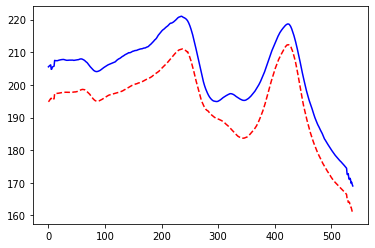

In [31]:
fig, ax = plt.subplots()
ax.plot(df['y_top_right'], '-b',label='y_top_right')
ax.plot(df['y_top_left'], '--r', label='y_top_left')

In [53]:
df = pd.read_csv('saved_points.csv', index_col=0)

def get_distance(corner_x, corner_y):
    return np.sqrt((df['center_x'] - df[corner_x]) ** 2 + (
                df['center_y'] - df[corner_y]) ** 2)

def apply_savgol(column_name, window = 23):
    return savgol_filter(df[column_name], window, 3)

df['center_x_1'] = (df['x_top_left'] + df['x_bot_right']) / 2
df['center_y_1'] = (df['y_top_left'] + df['y_bot_right']) / 2
df['center_x_2'] = (df['x_top_right'] + df['x_bot_left']) / 2
df['center_y_2'] = (df['y_top_right'] + df['y_bot_left']) / 2

df['center_x'] = (df['center_x_1'] + df['center_x_2']) / 2
df['center_y'] = (df['center_y_1'] + df['center_y_2']) / 2

df['dist_top_left'] = get_distance('x_top_left', 'y_top_left')
df['dist_bot_left'] = get_distance('x_bot_left', 'y_bot_left')
df['dist_top_right'] = get_distance('x_top_right', 'y_top_right')
df['dist_bot_right'] = get_distance('x_bot_right', 'y_bot_right')

df['left_height'] = np.sqrt((df['x_top_left']-df['x_bot_left'])**2 + (df['y_top_left']-df['y_bot_left'])**2)
df['top_width'] = np.sqrt((df['x_top_left']-df['x_top_right'])**2 + (df['y_top_left']-df['y_top_right'])**2)
df['right_height'] = np.sqrt((df['x_top_right']-df['x_bot_right'])**2+(df['y_top_right']-df['y_bot_right'])**2)
df['bot_width'] = np.sqrt((df['x_bot_left']-df['x_bot_right'])**2 + (df['y_bot_left']-df['y_bot_right'])**2)

df['width'] = (df['top_width'] + df['bot_width'])/2
df['height'] = (df['left_height'] + df['right_height'])/2

a = np.array(df[['x_top_right', 'y_top_right']])
b = np.array(df[['x_bot_left', 'y_bot_left']])

start_coordinate = np.array(df[['x_top_left', 'y_top_left']])

a = a-start_coordinate
b = b-start_coordinate

df['cos_alpha'] = np.sum(a*b, axis=1)/(np.linalg.norm(a, axis=1)*np.linalg.norm(b, axis=1))
df['angle'] = np.arccos(df['cos_alpha']) * (180/np.pi)

df.drop(columns=['center_x_1', 
                 'center_y_1', 
                 'center_x_2', 
                 'center_y_2',
#                  'left_height', 
#                  'top_width', 
#                  'right_height', 
#                  'bot_width'
                ], inplace=True)

# df["ratio"] = df['width']/df['height']
ratio = 6.65

lost_side = []
prev_x = df.loc[0]
for i in range(len(df)):
    data = df.loc[i]
    diff = data['dist_top_left'] - prev_x['dist_top_left']
    if abs(diff) > 7:
        lost_side.append(i)
    prev_x = data

unstable_left = np.zeros(df.shape[0])
unstable_right = np.zeros_like(unstable_left)

for i in lost_side:
    if abs(df.loc[i, 'x_top_left'] - df.loc[i - 1, 'x_top_left']) > 12:
        unstable_left[i] = 1

    if abs(df.loc[i, 'x_top_right'] - df.loc[i - 1, 'x_top_right']) > 12:
        unstable_right[i] = 1

df['unstable_right'] = unstable_right
df['unstable_left'] = unstable_left

y = lambda x: (x-x_top_left)*(y_top_right-y_top_left)/(x_top_right-x_top_left)+y_top_left

for x in range(df.shape[0]):
    row = df.loc[x]
    if row['unstable_right']:
        for position in range(x-10, x+10):
            x_top_left = df.loc[position, "x_top_left"]
            x_bot_left = df.loc[position, "x_bot_left"]
            x_top_right = df.loc[position, "x_top_right"]
            x_bot_right = df.loc[position, "x_bot_right"]
            y_bot_right = df.loc[position, "y_bot_right"]
            y_top_right = df.loc[position, "y_top_right"]
            y_top_left = df.loc[position, "y_top_left"]
            y_bot_left = df.loc[position, "y_bot_left"]
            
            tmp_x_top_right = x_top_left+df.loc[position, "left_height"]* \
                                        (ratio*df.loc[position, "angle"] /90)
            tmp_x_bot_right = x_bot_left+df.loc[position, "left_height"]* \
                                        (ratio*df.loc[position, "angle"] /90)
            
            df.loc[position, 'y_top_right'] = y(tmp_x_top_right)
            df.loc[position, 'y_bot_right'] = y(tmp_x_bot_right) + \
            df.loc[position, "left_height"] * \
            df.loc[position, "angle"] /90
            
            df.loc[position, "x_top_right"]=tmp_x_top_right
            df.loc[position, "x_bot_right"]=tmp_x_bot_right
    
    if row['unstable_left']:
        for position in range(x-10, x+10):
            x_top_left = df.loc[position, "x_top_left"]
            x_bot_left = df.loc[position, "x_bot_left"]
            x_top_right = df.loc[position, "x_top_right"]
            x_bot_right = df.loc[position, "x_bot_right"]
            y_bot_right = df.loc[position, "y_bot_right"]
            y_top_right = df.loc[position, "y_top_right"]
            y_top_left = df.loc[position, "y_top_left"]
            y_bot_left = df.loc[position, "y_bot_left"]

            tmp_x_top_left = x_top_right-df.loc[position, "right_height"] * \
                                        (ratio*df.loc[position, "angle"] /90)
                
            tmp_x_bot_left = x_bot_right-df.loc[position, "right_height"]* \
                                        (ratio*df.loc[position, "angle"] /90)
            
            df.loc[position, 'y_top_left'] = y(tmp_x_top_left)
            df.loc[position, 'y_bot_left'] = y(tmp_x_bot_left) + \
            df.loc[position, "right_height"] * \
            df.loc[position, "angle"] /90
            
            df.loc[position, "x_top_left"]=tmp_x_top_left
            df.loc[position, "x_bot_left"]=tmp_x_bot_right
            
    if row['x_top_right'] > 1280:
        df.loc[x, 'x_top_right'] = df.loc[x, 'x_top_left']+ df.loc[x, "left_height"]* \
                                        (ratio*df.loc[x, "angle"] /90)
    if row['x_bot_right'] > 1280:
        df.loc[x, 'x_bot_right'] = df.loc[x, 'x_top_left']+ df.loc[x, "left_height"]* \
                                        (ratio*df.loc[x, "angle"] /90)
        
    if row['x_top_left'] < 0:
        df.loc[x, 'x_bot_left'] = df.loc[x, 'x_top_right']- df.loc[x, "right_height"]* \
                                        (ratio*df.loc[x, "angle"] /90)
    if row['x_bot_left'] < 0:
        df.loc[x, 'x_bot_left'] = df.loc[x, 'x_top_right']- df.loc[x, "right_height"]* \
                                        (ratio*df.loc[x, "angle"] /90)
        
            
df["y_bot_right"] = df["y_top_right"]+df["height"] * (df["angle"]/ 90)
df["y_bot_left"] = df["y_top_left"]+df["height"] / (df["angle"]/ 90)


window = 19
df['x_top_right'] = wiener(df['x_top_right'], window)
df['x_bot_right'] = wiener(df['x_bot_right'], window)
df['x_top_left'] = wiener(df['x_top_left'], window)
df['x_bot_left'] = wiener(df['x_bot_left'], window)
        
window = 17
df['x_top_left'] = apply_savgol('x_top_left', window)
df['x_top_right'] = apply_savgol('x_top_right', window)
df['x_bot_left'] = apply_savgol('x_bot_left', window)
df['x_bot_right'] = apply_savgol('x_bot_right', window)

window = 21
df['y_top_left'] = apply_savgol('y_top_left', window)
df['y_top_right'] = apply_savgol('y_top_right', window)
df['y_bot_left'] = apply_savgol('y_bot_left', window)
df['y_bot_right'] = apply_savgol('y_bot_right', window)


# first_p = df.loc[:first_points][['x_top_left', 'y_top_left']]
# for n in range(df.shape[0]):
#     meash = np.array(df.loc[n][['x_top_left', 'y_top_left']])
#     meash = np.expand_dims(meash, 1).astype(np.float32)
#     kf.correct(meash)
#     x, y, _, _ = kf.predict()
#     df.loc[n, 'x_top_left'] = x[0]
#     df.loc[n, 'y_top_left'] = y[0]
# df.loc[:first_points][['x_top_left', 'y_top_left']] = first_p

# first_p = df.loc[:first_points][['x_top_right', 'y_top_right']]
# for n in range(df.shape[0]):
#     meash = np.array(df.loc[n][['x_top_right', 'y_top_right']])
#     meash = np.expand_dims(meash, 1).astype(np.float32)
#     kf.correct(meash)
#     x, y, _, _ = kf.predict()
#     df.loc[n, 'x_top_right'] = x[0]
#     df.loc[n, 'y_top_right'] = y[0]
# df.loc[:first_points][['x_top_right', 'y_top_right']] = first_p

# first_p = df.loc[:first_points][['x_bot_left', 'y_bot_left']]
# for n in range(df.shape[0]):
#     meash = np.array(df.loc[n][['x_bot_left', 'y_bot_left']])
#     meash = np.expand_dims(meash, 1).astype(np.float32)
#     kf.correct(meash)
#     x, y, _, _ = kf.predict()
#     df.loc[n, 'x_bot_left'] = x[0]
#     df.loc[n, 'y_bot_left'] = y[0]
# df.loc[:first_points][['x_bot_left', 'y_bot_left']] = first_p

# first_p = df.loc[:first_points][['x_bot_right', 'y_bot_right']]
# for n in range(df.shape[0]):
#     meash = np.array(df.loc[n][['x_bot_right', 'y_bot_right']])
#     meash = np.expand_dims(meash, 1).astype(np.float32)
#     kf.correct(meash)
#     x, y, _, _ = kf.predict()
#     df.loc[n, 'x_bot_right'] = x[0]
#     df.loc[n, 'y_bot_right'] = y[0]
# df.loc[:first_points][['x_bot_right', 'y_bot_right']] = first_p

* unstable_right 55
* unstable_right 131
* unstable_left 258
* unstable_left 426
* unstable_right 477

In [54]:
df.loc[p-10:p+10, ['x_bot_right', 'y_bot_right', 'x_top_right', 'y_top_right', 'height']]

,x_bot_right,y_bot_right,x_top_right,y_top_right,height
467,565.301100,213.283680,566.359372,191.278263,22.454555
468,564.445566,212.805901,565.481757,190.959398,22.203177
469,563.542216,212.408150,564.566173,190.728692,22.249153
470,562.586545,212.021953,563.606957,190.445465,21.960680
471,561.556398,211.654248,562.580114,190.143464,22.235503
472,560.466363,211.257232,561.500849,189.732936,21.373795
473,559.311986,210.945025,560.361686,189.387755,21.590729
474,558.078125,210.687999,559.146710,189.094027,20.481801
475,556.761819,210.365429,557.850616,188.654242,20.356869
476,555.346509,210.041172,556.461486,188.148073,21.079349


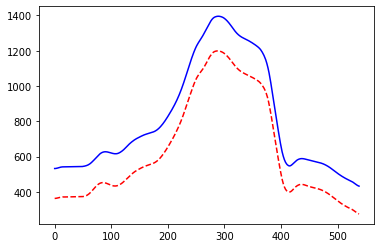

In [55]:
fig, ax = plt.subplots()
ax.plot(df['x_top_right'], '-b',label='y_top_right')
ax.plot(df['x_top_left'], '--r', label='y_top_left')

In [35]:
# for x in range(df.shape[0]):
#     row = df.loc[x]
#     shift = [x - 3, x + 3]
#     if row['unstable_right']:
#         df.loc[shift[0]:shift[1], 'x_top_right'] = np.mean(
#             df.loc[shift[0]:shift[1], 'x_top_right']) + np.std(
#             df.loc[shift[0]:shift[1], 'x_top_right'])
#         df.loc[shift[0]:shift[1], 'x_bot_right'] = np.mean(
#             df.loc[shift[0]:shift[1], 'x_bot_right']) + np.std(
#             df.loc[shift[0]:shift[1], 'x_bot_right'])
#         df.loc[shift[0]:shift[1], 'y_top_right'] = np.mean(
#             df.loc[shift[0]:shift[1], 'y_top_right']) + np.std(
#             df.loc[shift[0]:shift[1], 'y_top_right'])
#         df.loc[shift[0]:shift[1], 'y_bot_right'] = np.mean(
#             df.loc[shift[0]:shift[1], 'y_bot_right']) + np.std(
#             df.loc[shift[0]:shift[1], 'y_bot_right'])

#     if row['unstable_left']:
#         df.loc[shift[0]:shift[1], 'x_top_left'] = np.mean(
#             df.loc[shift[0]:shift[1], 'x_top_left']) + np.std(
#             df.loc[shift[0]:shift[1], 'x_top_left'])
#         df.loc[shift[0]:shift[1], 'x_bot_left'] = np.mean(
#             df.loc[shift[0]:shift[1], 'x_bot_left']) + np.std(
#             df.loc[shift[0]:shift[1], 'x_bot_left'])
#         df.loc[shift[0]:shift[1], 'y_top_left'] = np.mean(
#             df.loc[shift[0]:shift[1], 'y_top_left']) + np.std(
#             df.loc[shift[0]:shift[1], 'y_top_left'])
#         df.loc[shift[0]:shift[1], 'y_bot_left'] = np.mean(
#             df.loc[shift[0]:shift[1], 'y_bot_left']) + np.std(
#             df.loc[shift[0]:shift[1], 'y_bot_left'])

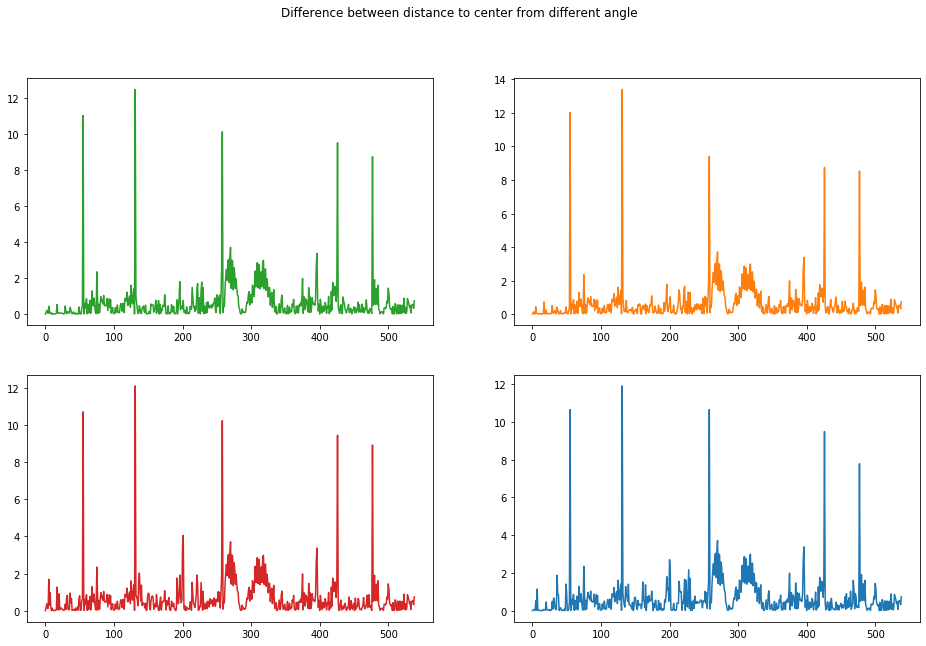

In [52]:
result = []
for x in ['dist_top_left', 'dist_bot_left', 'dist_bot_right', 'dist_top_right']:
    max_diff = 0
    diffs = []
    prev_x = df[x][0]
    for x in df[x]:
        diff = abs(x-prev_x)
        diffs.append(diff)
        if diff > max_diff:
            max_diff = diff
        prev_x = x
    result.append(diffs)
    
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
fig.set_size_inches(16, 10)
width = list(range(539))
fig.suptitle('Difference between distance to center from different angle')
ax1.plot(width, result[0], 'tab:green')
ax2.plot(width, result[1], 'tab:orange')
ax3.plot(width, result[2], 'tab:red')
ax4.plot(width, result[3])

In [53]:
# for i in range(len(df)):
#     data = df.loc[i]
#     if np.any(data[['x_top_right', 'x_bot_right']]>=1276):
#         right_intersection = True
#     elif np.any(data[['x_top_left', 'x_bot_left']]<=4):
#         left_intersection=True
#     else:
#         center=True
    
#     if right_intersection:
#         data['x_top_right'] = 

In [54]:
# df.to_csv('banner_data.csv')

In [55]:
# df['left_height'] = np.sqrt((df['x_top_left']-df['x_bot_left'])**2 + (df['y_top_left']-df['y_bot_left'])**2)
# df['top_width'] = np.sqrt((df['x_top_left']-df['x_top_right'])**2 + (df['y_top_left']-df['y_top_right'])**2)
# df['right_height'] = np.sqrt((df['x_top_right']-df['x_bot_right'])**2 + (df['y_top_right']-df['y_bot_right'])**2)
# df['bot_width'] = np.sqrt((df['x_bot_left']-df['x_bot_right'])**2 + (df['y_bot_left']-df['y_bot_right'])**2)

In [ ]:
x_df = df[['x_top_left', 'x_top_right', 'x_bot_left', 'x_bot_right']]
y_df = df[['y_top_left', 'y_top_right', 'y_bot_left', 'y_bot_right']]

In [ ]:
for i in range(y_df.shape[0]):
    cnt = np.array(list(map(lambda x, y: [x, y], list(x_df.loc[i]),list(y_df.loc[i])))).reshape((-1,1,2)).astype(np.int32)
    img = cv2.imread(f'masks/mask_{i}.jpg')
    cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
    cv2.imwrite(f'contour_images/img_{i}_1.jpg', img)

In [ ]:
x_df = df[['x_top_left', 'x_top_right', 'x_bot_left', 'x_bot_right']]
y_df = df[['y_top_left', 'y_top_right', 'y_bot_left', 'y_bot_right']]

In [ ]:
for i in range(y_df.shape[0]):
    cnt = np.array(list(map(lambda x, y: [x, y], list(x_df.loc[i]),list(y_df.loc[i])))).reshape((-1,1,2)).astype(np.int32)
    img = cv2.imread(f'masks/mask_{i}.jpg')
    cv2.drawContours(img, [cnt], 0, (0,255,0), 1)
    cv2.imwrite(f'contour_images/img_{i}_1.jpg', img)